In [1]:
import pandas as pd
import matplotlib.pyplot as plt

/Users/marcu/miniconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


import pandas as pd
import matplotlib.pyplot as plt


## Without buffering

   event_id                                               sent  \
0       701  Event(target=OpNode(User, InvokeMethod('login'...   
1       702  Event(target=OpNode(User, InvokeMethod('login'...   
2       703  Event(target=OpNode(User, InvokeMethod('login'...   
3       704  Event(target=OpNode(User, InvokeMethod('login'...   
4       705  Event(target=OpNode(User, InvokeMethod('login'...   

               sent_t                                                ret  \
0  (2, 1739890345710)  EventResult(event_id=701, result=True, metadat...   
1  (2, 1739890345710)  EventResult(event_id=702, result=True, metadat...   
2  (2, 1739890345710)  EventResult(event_id=703, result=True, metadat...   
3  (2, 1739890345710)  EventResult(event_id=704, result=True, metadat...   
4  (2, 1739890345710)  EventResult(event_id=705, result=True, metadat...   

                ret_t  roundtrip  flink_time               deser_times  loops  \
0  (2, 1739890345771)   0.054172    0.054172  [0.0001268386840820

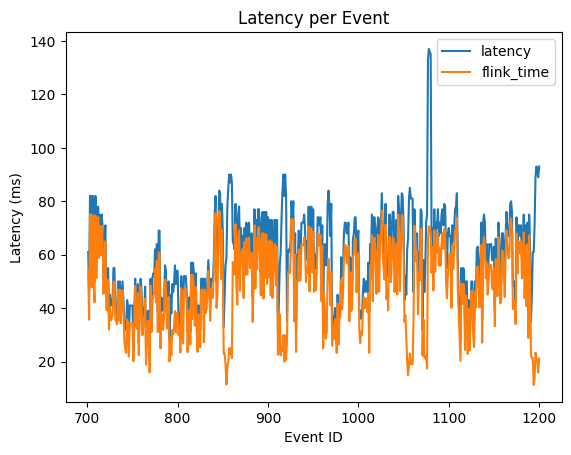

In [2]:
# Read the CSV file
df = pd.read_pickle('test_without_buffering.pkl')

# Display the first few rows of the dataframe to understand its structure
print(df.head())

df['flink_time'] = df['flink_time'] * 1000
df.plot(x='event_id', y=['latency', 'flink_time'], kind='line')
plt.xlabel('Event ID')
plt.ylabel('Latency (ms)')
# plt.yscale('log')
plt.title('Latency per Event')
plt.show()

## With buffering

   event_id                                               sent  \
0       701  Event(target=OpNode(User, InvokeMethod('login'...   
1       702  Event(target=OpNode(User, InvokeMethod('login'...   
2       703  Event(target=OpNode(User, InvokeMethod('login'...   
3       704  Event(target=OpNode(User, InvokeMethod('login'...   
4       705  Event(target=OpNode(User, InvokeMethod('login'...   

               sent_t                                                ret  \
0  (2, 1739890234212)  EventResult(event_id=701, result=True, metadat...   
1  (2, 1739890234212)  EventResult(event_id=702, result=True, metadat...   
2  (2, 1739890234212)  EventResult(event_id=703, result=True, metadat...   
3  (2, 1739890234212)  EventResult(event_id=704, result=True, metadat...   
4  (2, 1739890234212)  EventResult(event_id=705, result=True, metadat...   

                ret_t  roundtrip  flink_time               deser_times  loops  \
0  (2, 1739890234316)   0.061799    0.061799   [2.193450927734375

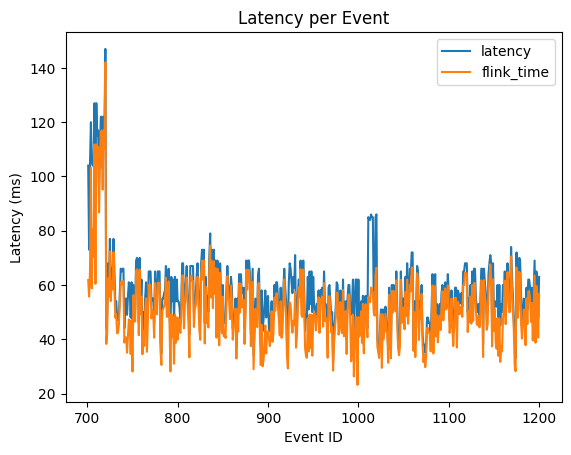

In [3]:
# Read the CSV file
df = pd.read_pickle('test_with_buffering.pkl')

# Display the first few rows of the dataframe to understand its structure
print(df.head())

df['flink_time'] = df['flink_time'] * 1000
df.plot(x='event_id', y=['latency', 'flink_time'], kind='line')
plt.xlabel('Event ID')
plt.ylabel('Latency (ms)')
# plt.yscale('log')
plt.title('Latency per Event')
plt.show()

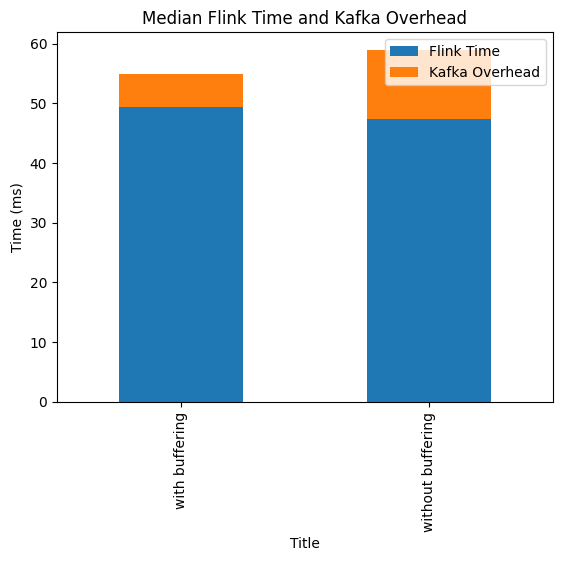

In [6]:
def preprocess_data(pickle_file_path):
    # Read the DataFrame from the pickle file
    df = pd.read_pickle(pickle_file_path)

    # Multiply flink_time by 1000 to convert to milliseconds
    df['flink_time'] = df['flink_time'] * 1000

    # Calculate the additional Kafka overhead
    df['kafka_overhead'] = df['latency'] - df['flink_time']

    # Extract median values from df
    flink_time_median = df['flink_time'].median()
    latency_median = df['latency'].median()

    return {
        'flink_time_median': flink_time_median,
        'kafka_overhead_median': latency_median - flink_time_median
    }

# List of pickle files
titles = ['without buffering', 'with buffering', ]
pickle_files = ['test_without_buffering.pkl', 'test_with_buffering.pkl']


# Process each file and collect median data
all_median_data = []
for title, file in zip(titles, pickle_files):
    median_values = preprocess_data(file)
    all_median_data.append({
        'Metric': 'Flink Time',
        'Value': median_values['flink_time_median'],
        'Title': title
    })
    all_median_data.append({
        'Metric': 'Kafka Overhead',
        'Value': median_values['kafka_overhead_median'],
        'Title': title
    })

# Create a DataFrame for all median values
all_median_df = pd.DataFrame(all_median_data)

# Sort titles based on 'Flink Time' in descending order
sorted_titles = (
    all_median_df[all_median_df['Metric'] == 'Flink Time']
    .sort_values(by='Value', ascending=False)['Title']
)

# Pivot the DataFrame and reindex to maintain sorted order
pivot_df = (
    all_median_df.pivot(index='Title', columns='Metric', values='Value')
    .reindex(sorted_titles)
)

# Plot
fig, ax = plt.subplots()
pivot_df.plot(kind='bar', stacked=True, color=['#1f77b4', '#ff7f0e'], ax=ax)
plt.ylabel('Time (ms)')
plt.title('Median Flink Time and Kafka Overhead')
plt.legend(['Flink Time', 'Kafka Overhead'])
plt.show()